# Introduction

<h1>Text classification - Are you a Plato?</h1>

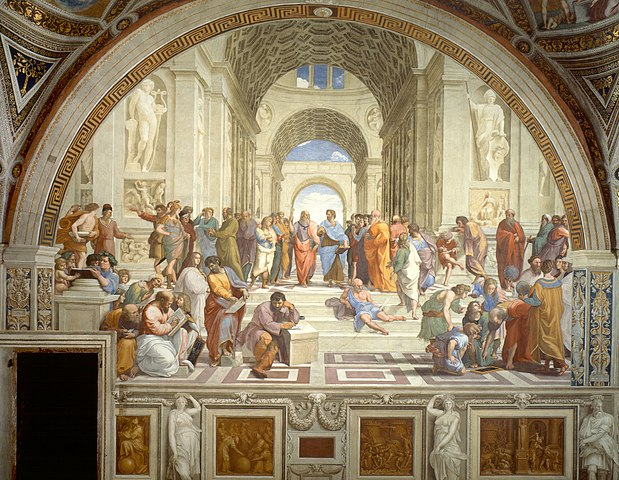

> The greatest challenge to any thinker is stating the problem in a way that will allow a solution.

<a href="https://en.wikipedia.org/wiki/Bertrand_Russell">Bertrand Russell</a>
<br><br>
<h2>About the project</h2>
Philosophy is a fundamental human thought movement. Everyone is a philosopher. The only question is what kind of philosopher you are. This project tries to answer that question.<br>
Using natural language processing (NLP), texts of different authors are used for categorization.<br>
With the help of these texts any sentence can be categorically determined.
To understand how written language works and what the differents are between authors it helps to analyse the context of the sentences. Though visualization it is simpler to see structural varieties such as average sentence length, word class ratio and the use of <a href="https://en.wikipedia.org/wiki/Stop_word">stop words</a>.
<br><br>

<h2>Information on use</h2>
Some processes may take a while depending on the settings and hardware requirements. To speed up the process, certain changes can be made. Obviously, the total amount of data also determines the overall speed.
<ul>
<li>The easiest way to speed up all processes is to switch to <code>test_mode</code>. This will have a strong impact on the results. Lemmatization and pos tagging is <b>not</b> disabled in <code>test_mode</code>.
<li>Adjust the parameters to fit your needs
  <ul>
    <li><code>epochs</code> - Iterations for training</li>
    <li><code>search_epochs</code> - Iterations for finding the best hyperparameters</li>
    <li><code>executions_per_trial</code> - Number of models that should be built and fit for each trial for robustness purposes.</li>
  </ul>   
</li>
<li><code>hyperband_iterations</code> - The number of times to iterate over the full Hyperband algorithm.</li>
<li>POS tagging - this process uses Scad not be executedpy to tag every word in a sentence. Set <code>lemmatization_enabled</code> to <code>False</code> to skip it.</li>
<li>Prepare values for visualization - if <code>lemmatization_enabled</code> is set to <code>True</code> the list of unique vocabulary for each author is lemmatized. This will slow down the process.</li>
</ul>
<br>
<h2>Content</h2>

* [1. Preparations](#1)
* [2. Loading text data](#2)
* [3. Collect and clean data](#3)
* [4. Create and extend DataFrame](#4)
* [5. Visualization of data](#6)
* [6. Prepare and split](#7)
* [7. Hyperparameter tuning](#8)
* [8. Model preparation and training](#9)
* [9. Evaluation](#11)






# 1. Preparations <a class="anchor" id="1"></a>

## 1.1. Installs and imports

In [ ]:
!pip install -q -U keras-tuner

import spacy.cli
spacy.cli.download('en_core_web_md')

In [ ]:
import urllib, IPython, re, nltk, codecs, datetime, operator, random, json, multiprocessing, gc, os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, \
  Bidirectional, Dropout, BatchNormalization, GlobalAveragePooling1D 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers
import kerastuner as kt
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from wordcloud import WordCloud
from collections import Counter
import spacy
from spacy.lemmatizer import Lemmatizer
from spacy import displacy
import en_core_web_md
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
%matplotlib inline

## 1.2. Set variables<a class="anchor" id="1-2-1"></a>

**This is the place where some information is needed. Please go though the steps and modify the information according to your needs.**

For tesing the notebook set `test_mode` to `True`. POS tagging and lemmatization will **not** be disabled.

In [ ]:
test_mode = True

Parameters needed for tuning and training. In test mode those parameters will be overwritten.

In [ ]:
batch_size=20
epochs=30
search_epochs=10
early_stopping_patience=5
executions_per_trial=1
hyperband_iterations=1

List of files to process and author names. Files should be named after author (e.g. `plato.txt`). `file_names` should contain at least 3 files.

In [ ]:
file_names = [
    'kant.txt', 
    'aristotle.txt', 
    'plato.txt', 
    'hume.txt',
    'nietzsche.txt'
    ]

Print available files

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
source_path = os.path.abspath('/kaggle/input/philosophical-texts')

Set min and max length for sentences

In [ ]:
min_length = 4
max_length = 100

## 1.4. Downloads for NLTK and Spacy

In [ ]:
nltk.download('punkt')
spacy.prefer_gpu()
nlp = en_core_web_md.load()

# 2. Loading text data <a class="anchor" id="2"></a>

In [ ]:
if test_mode == True:
  file_names = file_names[0:3]

for file_name in file_names:
  text_dir = tf.keras.utils.get_file(file_name, origin=f'file://{source_path}/{file_name}')

parent_dir = os.path.dirname(text_dir)

# 3. Collect and clean data <a class="anchor" id="3"></a>

## 3.1. Extract sentences

Extract sentences from files and creates labels list.

In [ ]:
labels = []
sentences = []

for index, file_name in enumerate(file_names):

  path = os.path.join(parent_dir, file_name)

  with codecs.open(path, 'rb', 'utf-8') as file: 
    text = str(file.read())
    nltk_sentences = nltk.sent_tokenize(text, language='english')

    for sentence in nltk_sentences:
      sentence = str(sentence).replace("b'", "")
      sentences.append(sentence)
      labels.append(index)

    print(f'Sentences for {file_name} with label: {index} added.')

print(f'\n{len(sentences)} sentences found.')

## 3.2. Clean data

In [ ]:
def clean_up(text):
    text = text.replace(' ', ' ')
    text = text.replace('–', '-')
    text = text.replace('\n', ' ')
    text = re.sub(r'[IVXLCDM]+\.', '', text)
    text = re.sub(r'\[[^]]*\]', '', text)
    text = re.sub(r'\((.*?)\)', '', text)
    text = re.sub(r'\{(.*?)\}', '', text)
    text = re.sub(r'\b[A-Z]{2,}\b', '', text)
    text = text.replace(' ,', ',')
    text = text.replace(' .', '.')
    text = text.replace(' ;', ';')
    text = re.sub(r'[^A-Za-z0-9äÄöÖüÜß\s\.\-\!\?\:\;\,]', '', text)
    text = re.sub(r' +', ' ', text)
    return text

In [ ]:
pre_cleaned_sentences = [clean_up(sentence) for sentence in sentences]

In [ ]:
def short_sentences(length):
  short_sentences = [sentence for sentence in pre_cleaned_sentences if len(sentence.split()) <= length]
  print(f'Found {len(short_sentences)} sentences shorter than {length} words.\n')
  return short_sentences

def long_sentences(length):
  long_sentences = [sentence for sentence in pre_cleaned_sentences if len(sentence.split()) >= length]
  print(f'Found {len(long_sentences)} sentences longer than {length} words.\n')
  return long_sentences

### 3.2.1. Remove sentences

Get invalid sentences

In [ ]:
invalid_sentences = short_sentences(min_length) + long_sentences(max_length)
print(f'Found {len(invalid_sentences)} invalid sentences.')

#### 3.2.1.1. Investigate invalid sentences
Print 5 examples of `invalid_sentences`

In [ ]:
for i in random.sample(range(10, len(invalid_sentences)-1), 10):
    print(invalid_sentences[i])

Use Spacy [Visualizer](https://spacy.io/usage/visualizers) to show a random invalid sentence.

In [ ]:
if tf.test.gpu_device_name() == '': # Needed to avoid chash in Spacy when running on GPU.
  doc = nlp(invalid_sentences[random.randint(0, len(invalid_sentences)-1)])
  displacy.render(doc, style="dep", jupyter=True, options={'compact':'True'})

### 3.2.2. Provide cleaned data

In [ ]:
cleaned_labels = []
cleaned_sentences = []
print(f"'sentences' list length before removal: {len(pre_cleaned_sentences)}.")
for index, sentence in enumerate(pre_cleaned_sentences):
  if sentence not in invalid_sentences:
    cleaned_sentences.append(sentence)
    cleaned_labels.append(labels[index])  
print(f"'sentences' list length after removal: {len(cleaned_sentences)}.")
print(f'{len(invalid_sentences)} sentences removed.')

Print longest valid sentence

In [ ]:
print(max(cleaned_sentences, key=len))

Use Spacy [Visualizer](https://spacy.io/usage/visualizers) to show the longest valid sentence.

In [ ]:
if tf.test.gpu_device_name() == '': # Needed to avoid chash in Spacy when running a GPU.
  doc = nlp(max(cleaned_sentences, key=len))
  displacy.render(doc, style="dep", jupyter=True, options={'compact':'True'})

# 4. Create and extend DataFrame <a class="anchor" id="4"></a>

Some helper methods

In [ ]:
def stop_word_ratio_fn(sentence):
  count = 0
  for word in sentence.split():
    word = re.sub(r"[^a-zA-Z]+", "", word)
    if word.lower() in STOP_WORDS:
      count += 1
  return round(count/len(sentence.split()) * 100, 2)

def stop_word_count_fn(sentence):
  count = 0
  for word in sentence.split():
    word = re.sub(r"[^a-zA-Z]+", "", word)
    if word.lower() in STOP_WORDS:
      count += 1
  return count

def mean_word_length_fn(sentence):
  return round(np.array([len(word) for word in sentence.replace('.','').split()]).mean(), 2)

def pos_count(sentence, pos):
  doc = nlp(sentence)
  return len([w.pos_ for w in doc if w.pos_ == pos])

## 4.1. Create DataFrame

In [ ]:
df = pd.DataFrame({'label': cleaned_labels, 'sentence': cleaned_sentences})
df.head()

## 4.2. Construct new data

In [ ]:
author_names = [name[:-4].capitalize() for name in file_names]

In [ ]:
df['author'] = df['label'].map(lambda x: author_names[x])
df['word_count'] = df['sentence'].str.split().str.len()
df['mean_word_length'] = df['sentence'].map(mean_word_length_fn)
df['stop_words_ratio'] = df['sentence'].map(stop_word_ratio_fn)
df['stop_words_count'] = df['sentence'].map(stop_word_count_fn)

### 4.2.1. POS tagging <a class="anchor" id="4-2-*1*"></a>
Add columns and values for [POS tagging](https://en.wikipedia.org/wiki/Part-of-speech_tagging).A list of tags can be found [here](https://spacy.io/api/annotation). **This may take a while!**

In [ ]:
pos_tagging_enabled = False

In [ ]:
if pos_tagging_enabled == True:
  pos_tags = {'ADJ':'adjective', 'ADV':'adverb', 'ADP':'adposition', 
              'AUX':'auxiliary', 'DET':'determiner', 'NUM':'numeral', 
              'X':'other', 'INTJ':'interjection', 'CONJ':'conjunction', 
              'CCONJ':'coord. conjunction', 'SCONJ':'subord. conjunction', 
              'PROPN':'proper noun', 'NOUN':'noun', 'PRON':'pronoun', 
              'PART':'particle', 'VERB':'verb'}
            
  for tag in list(pos_tags.keys()):
    df[f'{tag}_count'] = df['sentence'].map(lambda sen: pos_count(sen, tag))

## 4.3. Preview processed DataFrame

In [ ]:
df.head(df.shape[0])

# 5. Visualization of data <a class="anchor" id="6"></a>

## 5.1 Prepare values for visualization

Prepare values for visualization. Enable [lemmatization](https://en.wikipedia.org/wiki/Lemmatisation) to get more a more prezise `unique_vocabulary_count`, `words_without_stop_words`, and `most_common`. **This will slow down the process!**

In [ ]:
lemmatization_enabled = False

In [ ]:
def lemmatize(sentence):
  words = set()
  doc = nlp(sentence)
  for word in doc:
    words.add(word.lemma_)
  return list(words)

Helper functions

In [ ]:
def vocabulary_count_fn(series, lemmatization):
  vocabulary = set()
  for sentence in series:
    if lemmatization == True:
      words = lemmatize(sentence)
    else:
      words = sentence.split()  
    for word in words:
      if word.lower() not in STOP_WORDS and word is not '':
        word = re.sub(r'[^a-zA-Z]+', '', word)
        vocabulary.add(word.lower())
  return len(vocabulary)

In [ ]:
def non_stop_words_vocab(sentences):
  words_without_stop_words = []
  for sentence in sentences:
    for word in sentence.split():
      word = re.sub(r'[^a-zA-Z]+', '', word)
      if word.lower() not in STOP_WORDS and word is not '':
        words_without_stop_words.append(word)
  return words_without_stop_words

In [ ]:
words_without_stop_words = non_stop_words_vocab(df['sentence'].values)
most_common = [word[0] for word in Counter(words_without_stop_words).most_common(20)]
most_common_count = {key: value for key, value in Counter(words_without_stop_words).most_common(20)}

### 5.1.1. Prepare values for visualization <a class="anchor" id="6-1-1"></a>

In [ ]:
author_names = df['author'].unique()
median_sentence_length = df.groupby('author')['word_count'].median()
mean_word_length = df.groupby('author')['mean_word_length'].mean()
median_stop_words = df.groupby('author')['stop_words_ratio'].median()
author_sentence_count = df.groupby('author')['sentence'].count()
author_unique_vocabulary_count = df.groupby('author')['sentence'] \
  .apply(lambda ser: vocabulary_count_fn(ser, lemmatization_enabled))

Create POS tag data frame if tags are available in dataframe

In [ ]:
if 'ADJ_count' in df:
  pos_tags = {'ADJ':'adjective', 'ADV':'adverb', 'ADP':'adposition', 
              'AUX':'auxiliary', 'DET':'determiner', 'NUM':'numeral', 
              'X':'other', 'INTJ':'interjection', 'CONJ':'conjunction', 
              'CCONJ':'coord. conjunction', 'SCONJ':'subord. conjunction', 
              'PROPN':'proper noun', 'NOUN':'noun', 'PRON':'pronoun', 
              'PART':'particle', 'VERB':'verb'}

  pos_df = df.groupby('author') \
  [[f'{tag}_count' for tag in list(pos_tags.keys())]+['word_count']] \
  .sum().apply((lambda x: x/x['word_count']*100), axis=1) \
  .drop('word_count', axis=1)

## 5.2. Draw visualization

Set matplotlib style

In [ ]:
plt.style.use('fivethirtyeight') 

### 5.2.1 Data distribution
The data should be equally split between authors.

In [ ]:
plt.pie(df['author'].value_counts(),
        explode=np.full(len(author_names), 0.1),
        radius=2,
        autopct='%1.0f%%', 
        labels=author_names,
        shadow=True,
        startangle=90,
        textprops={'size': 15})
plt.show()

### 5.2.2. Comparing authors

Draw distribution of word lengths by author

In [ ]:
vocab_length = df.groupby('author')['sentence'] \
  .apply(' '.join) \
  .apply (lambda x: re.sub(r"[^a-zA-Z\s]+", "", x).lower()) \
  .apply(lambda x: [len(word) for word in x.split() \
   if word not in STOP_WORDS])

voc_list = []
for i in range(len(author_names)):
  voc_list.append(vocab_length[i])

plt.figure(figsize=(15,7))
plt.hist(voc_list, bins=10, alpha=0.8, range=(0,20), log=True)
plt.xlabel('Length of word')
plt.ylabel('Word count')
plt.legend(labels=author_names)
plt.show()

In [ ]:
sent_length = df.groupby('author')['word_count'].apply(lambda x: x.values)

sent_list = []
for i in range(len(author_names)):
  sent_list.append(sent_length[i])

plt.figure(figsize=(15,7))
plt.hist(sent_list, bins=20, alpha=0.8, range=(min_length, max_length), log=True)
plt.xlabel('Length of sentence')
plt.ylabel('Sentence count')
plt.legend(labels=author_names)
plt.show()

Compate different metrics between authors

In [ ]:
fig, axs = plt.subplots(5,1, figsize=(10,15))
fig.tight_layout()

axs[0].bar(author_names, author_sentence_count, alpha=0.7)
axs[0].set_ylabel('Number of sentences')

axs[1].bar(author_names, median_sentence_length, alpha=0.7)
axs[1].set_ylabel('Median sentence lenth')

axs[2].bar(author_names, mean_word_length, alpha=0.7)
axs[2].set_ylabel('Mean word length')

axs[3].bar(author_names, author_unique_vocabulary_count, alpha=0.7)
axs[3].set_ylabel('Unique vocabulary count\n(excl. stop words)')

axs[4].bar(author_names, median_stop_words, alpha=0.7)
axs[4].set_ylabel('Median stop words ratio')

plt.show()

Word classes by authors. A list of tags can be found [here](https://spacy.io/api/annotation).

In [ ]:
if 'pos_df' in locals() and 'pos_tags' in locals():
  ax = pos_df.plot(kind='barh', figsize=(15,15), alpha=0.8)
  ax.set_xlabel('Percentage of word class in vocabulary')
  ax.set_ylabel('Author')
  ax.legend(pos_tags.values())
  ax.xaxis.set_tick_params(labeltop='on')
  plt.show()
else:
  print("'pod_df' or 'pos_tags' not available!") 

### 5.2.3. Common words

In [ ]:
plt.figure(figsize=(30,10))
plt.bar(most_common_count.keys(), 
        most_common_count.values(), 
        color='orange', 
        alpha=0.8)

plt.ylabel('Number of sentences')
plt.show()

### 5.2.4. Sentences by authors
This shows the sentence structure, lemmas, and pos tags of one random sentences from each author.

In [ ]:
if tf.test.gpu_device_name() == '': # Needed to avoid chash in Spacy when running on GPU.
  for author in author_names:
    sentences_series = df.loc[(df['author'] == author) & 
                              (df['sentence'].str.len() < 50)]['sentence']
    print(f'\nSentence by {author}:')
    doc = nlp(sentences_series.sample(n=1).values[0])
    displacy.render(doc, 
                    style="dep", 
                    jupyter=True, 
                    options={'compact':'True', 'add_lemma': 'True'})

### 5.2.5. Word cloud

In [ ]:
wordcloud_size = 60
wordcloud_words = {k: v for k, v in Counter(words_without_stop_words).most_common(wordcloud_size)}
wordcloud = WordCloud(width=5000, 
                      height=4000,
                      max_words=wordcloud_size,  
                      background_color ='white', 
                      stopwords = STOP_WORDS, 
                      min_font_size = 10).generate_from_frequencies(wordcloud_words) 

plt.figure(figsize=(20, 12), facecolor='k', edgecolor ='k') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0) 
plt.show() 

# 6. Prepare and split <a class="anchor" id="7"></a>

## 6.1. Tokenize

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['sentence'].values)
print(f"{len(df['sentence'].values)} sentences from {len(file_names)} authors.")
print(f'{len(tokenizer.word_counts)} unique vocabularies tokenized.')

## 6.2. Encode

In [ ]:
encoded_sentences = tokenizer.texts_to_sequences(df['sentence'].values)
padded_sentences = pad_sequences(encoded_sentences, padding='post')
print(f"{len(padded_sentences)} sentences padded.")

## 6.3. Create new data frames

Create a new data frame which contains only the `patted_sentences` and the labels

In [ ]:
padded_sentence_df = pd.DataFrame(padded_sentences, 
                                  columns=[f'loc_{i}' for i in range(len(padded_sentences[0]))])

In [ ]:
padded_sentence_df['label'] = df['label']

In [ ]:
padded_sentence_df.drop(padded_sentence_df[padded_sentence_df.loc_0 == 0].index, inplace=True)

Test the encoder

In [ ]:
print(df['sentence'].values[0])
print(padded_sentence_df.iloc[0].values)
print(tokenizer.sequences_to_texts([padded_sentence_df.iloc[0].values]))

Remove 90% of `padded_sentence_df` rows for testing.

In [ ]:
if test_mode == True:
  print(f'Before drop: {padded_sentence_df.shape}')
  padded_sentence_df = padded_sentence_df.drop(padded_sentence_df.sample(frac=0.9).index)
  print(f'After drop: {padded_sentence_df.shape}')
else:
  print('Test mode not enabled - nothing dropped.')

## 6.4. Splitting
Create train and test data for the fitting proccess.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    padded_sentence_df.drop('label', axis=1).values ,
    padded_sentence_df['label'].values, 
    test_size=0.1)

print(f'Shape of the splited X_train: {X_train.shape}')
print(f'Shape of the splited y_train: {y_train.shape}')
print(f'Shape of the splited X_valid: {X_valid.shape}')
print(f'Shape of the splited y_valid: {y_valid.shape}')

# 7. Hyperparameter tuning <a class="anchor" id="8"></a>

## 7.1. Setup the hypermodel

For the word embeddings we use [Wiki-words-250](https://tfhub.dev/google/Wiki-words-250/2) provided by Tensorflow Hub.

In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/Wiki-words-250/2", input_shape=[], dtype=tf.string)
embeddings = hub_layer.get_weights()[0]

Collection of hyperparameters

In [ ]:
def hyperparameter_dict(hp):
    if test_mode == False:
      return {
        'dense_units_count': hp.Int(f'dense_units_count', 128, 512, step=128),
        'lstm_units_count': hp.Int('lstm_units_count', 64, 256, step=64),
        'dropout_rate': hp.Choice('dropout_rate', [0.25, 0.5]),
        'learning_rate': hp.Choice('learning_rate', [0.001, 0.0001]),
        'adam_epsilon': hp.Choice('adam_epsilon', [1e-07, 1e-08])
      }

    return {
      'dense_units_count': hp.Int(f'dense_units_count', 64, 128, step=64),
      'lstm_units_count': hp.Int('lstm_units_count', 32, 64, step=32),
      'dropout_rate': hp.Choice('dropout_rate', [0.25]),
      'learning_rate': hp.Choice('learning_rate', [0.001]),
      'adam_epsilon': hp.Choice('adam_epsilon', [1e-08])
    }

Model definition

In [ ]:
def hypermodel(hp):
  hyp = hyperparameter_dict(hp)

  input = Input(shape=(X_train.shape[1],))

  x = Embedding(len(embeddings),
            output_dim=embeddings.shape[1],
            weights=[embeddings], 
            trainable=False,
            mask_zero=True)(input)

  x = Bidirectional(LSTM(hyp['lstm_units_count'], return_sequences=True))(x)
  x = BatchNormalization()(x)
  x = Dropout(hyp['dropout_rate'])(x)

  x = Bidirectional(LSTM(hyp['lstm_units_count'], return_sequences=False))(x)
  x = BatchNormalization()(x)  
  x = Dropout(hyp['dropout_rate'])(x)

  x = Dense(hyp['dense_units_count'], activation='relu')(x)

  predictions = Dense(len(file_names), activation='softmax')(x)

  model = Model(inputs=input, outputs=predictions)
  
  model.compile(optimizer=optimizers.Adam(learning_rate=hyp['learning_rate'], epsilon=hyp['adam_epsilon']),
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  return model

## 7.2. Prepare and run the tuner
Reduce parameters for `testing_mode`

In [ ]:
if test_mode == True:
  epochs=10
  search_epochs=1
  early_stopping_patience=5
  executions_per_trial=1
  hyperband_iterations=1

Set variables

In [ ]:
train_search_limit = int((len(X_train)*0.1))
valid_search_limit = int((len(X_valid)*0.1))
if test_mode == True:
  max_epochs = 1

Prepare the hyperband tuner

In [ ]:
tuner = kt.Hyperband(hypermodel,
                     objective='val_accuracy', 
                     executions_per_trial=executions_per_trial,
                     max_epochs=epochs,
                     hyperband_iterations=hyperband_iterations,
                     project_name='text_classifier',
                     overwrite=True)

Run the tuner to search for best parameters. The result are the optimal hyperparameters: `best_hps` and a list of `best_models`.

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait=True)

class GarbageCollector(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

tuner.search(X_train[0:train_search_limit], y_train[0:train_search_limit], 
             epochs=search_epochs,
             validation_data=(X_valid[0:valid_search_limit], y_valid[0:valid_search_limit]),
             batch_size=batch_size,
             callbacks=[ClearTrainingOutput(), GarbageCollector(), EarlyStopping('val_accuracy', patience=1)],
             use_multiprocessing=True,
             workers=multiprocessing.cpu_count(),
             verbose=1)

best_hps = tuner.get_best_hyperparameters(1)[0]
best_models = tuner.get_best_models(num_models=3)

tuner.results_summary()

# 8. Model preparation and training <a class="anchor" id="9"></a>

Get summaries of the best models and choose the model for training.

In [ ]:
for model in best_models:
  model.summary()

Choose preferred model

In [ ]:
chosen_model = best_models[0]
del best_models

Plot model structure

In [ ]:
plot_model(chosen_model, show_shapes=True, show_layer_names=True)

Create `EarlyStopping` callback

In [ ]:
es_callback = EarlyStopping('val_accuracy', patience=early_stopping_patience, restore_best_weights=True)

## 8.2. Model training

In [ ]:
h = chosen_model.fit(X_train, 
                      y_train, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(X_valid, y_valid), 
                      callbacks=[es_callback, GarbageCollector()],
                      use_multiprocessing=True,
                      workers=multiprocessing.cpu_count(),
                      verbose=1)

# 9. Evaluation <a class="anchor" id="11"></a>

Draw charts to show compare training and validation results

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(8, 6))

epochs = range(len(h.history['accuracy']))
axs[0].plot(epochs, h.history['accuracy'], color='red', marker='x')
axs[0].plot(epochs, h.history['val_accuracy'], color='green', marker='.')
axs[0].legend(labels=['Training accuracy','Validation accuracy'])
axs[0].set_ylabel('Accuracy', fontdict={'color':'gray', 'size':12})
axs[0].tick_params(labelbottom=False)
axs[0].grid()

epochs = range(len(h.history['loss']))
axs[1].plot(epochs, h.history['loss'], color='red', marker='x')
axs[1].plot(epochs, h.history['val_loss'], color='green', marker='.')
axs[1].legend(labels=['Training loss','Validation loss'])
axs[1].set_ylabel('Loss', fontdict={'color':'gray', 'size':12})
axs[1].tick_params(labelbottom=False)
axs[1].grid()

plt.show()

## 9.1. Test the model

Test the model. Add  `sample_sentences` to get the probability distribution for each author.

In [ ]:
sample_sentences = ["Here you can try your own sentences.", "Let's see what kind of philosopher you are."]

In [ ]:
encoded_sample_sentences = tokenizer.texts_to_sequences(sample_sentences)
padded_sample_sentences = pad_sequences(encoded_sample_sentences, maxlen=X_train.shape[1], padding='post')
predictions = model.predict(padded_sample_sentences)

predictions_df = pd.DataFrame()
for index, prediction in enumerate(predictions):
  for i, pre in enumerate(prediction):
    predictions_df = predictions_df.append({
      'sentence_number': index,
      'author': author_names[i],
      'prediction': pre,
      'sentence': sample_sentences[index]
    }, ignore_index=True)

predictions_df.head(predictions_df.shape[0])

Draw bars for each sample sentence

In [ ]:
fig, axs = plt.subplots(len(predictions), 1, figsize=(10,10))
fig.tight_layout(h_pad=6)
for sen_id, pre in enumerate(predictions):
  for i, p in enumerate(pre):
    axs[sen_id].barh(author_names, pre)
    axs[sen_id].set_title(f'Sentence {sen_id}: {sample_sentences[sen_id][0:70]}...')
    axs[sen_id].set_ylabel('Author')
    axs[sen_id].set_xlabel('Probability')    
    axs[sen_id].grid()

plt.show()